In [358]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
from matplotlib.patches import Rectangle
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
from tensorflow.keras import layers
warnings.resetwarnings()


To accomplish this, I will produce a number of "new" features which attempt to capture the time dependence via rolling averages and rolling standard deviations. I will also one-hot encode certain variables which represent flags for certain behaviors or discrete, time independent variables such as location (country).

The models will be trained using data from all countries; that is, the models will not be country-specific. 
The prediction require shifting the target variable (number new cases) by the corresponding number of days
the specific model is trying to predict.

Analysis of this forecasting method will be performed by not only comparing the predictions from different days (e.g. I expect the standard deviation to increase the further into the future the model is predicting) but also comparing the results against a baseline model. I consider three baseline models: a naive model, which just uses the last known value, a drift model, which
extrapolates using the average rate of change, and the average method, which uses the average the entire history.

Due to the nature of testing, most of the time series (of the number of new cases) start at 0 for a protracted period of time (i.e. testing begins far after the first date in the time series). This property is hard to capture with either a drift or an average method, as they would both be biased by these long tails. Therefore, while the simplest choice, I will elect to simply use a naive method; alternative ideas I had were to use a drift or average method which does not utilize the entire history but rather only the most recent $d$ days, or at very least only incorporate the non-zero values.


## Baseline comparisons.

Because I am predicting the number of new cases per million on a daily basis, (i.e. not the rate) I am going to employ a naive (constant) baseline.


## Metric to determine model accuracy

I will be using mean absolute error as to minimize the effect of outliers.


## Details yet to be incorporated:

Growth of standard deviation over time in forecasting.


# Modeling the number of cases of COVID-19


# Table of contents<a id='toc'></a>

## [COVID-19 Case number modeling ](#model)


## [COVID-19 Case number modeling with new features.](#modelplus)
***This section is a repeat of calculations with different data; the steps are described in the first modeling section.***

In [331]:
# Copied from last capstone project. 
def classifier_analysis(clf, X_test, y_test, plot=True, metric='evs'):
    
    '''
        Predict using trained scikit-learn estimator and compute and plot various metrics:
        Prints 
        
        Parameters:
        
        X_test : ndarray or DataFrame (n_samples, n_features)
                 Feature data to test. n_features represents the number of features
                 present in the data used to train the estimator clf
                 
        y_test : ndarray (n_samples, )
                 Target data to test. 
                
        
        clf : scikit-learn estimator which has been fit to data with same number of 
              columns as X_test
        
        
        Returns:
        
        y_test : ndarray (n_samples, )
            
            Same as input for convenience
        
        y_predict : ndarray (n_samples, ) 
            
            Predictions 
        
    '''
    
    y_predict = clf.predict(X_test)
    
    # Print the mean squared error and explained variance
    if metric == 'evs':
        score = explained_variance_score(y_test, y_predict)
    elif metric == 'mae':
        score = mean_absolute_error(y_test, y_predict)
    else:
        score = mean_squared_error(y_test, y_predict)

#     print('Mean squared error {}'.format(mse_))
#     print('Explained variance score {}'.format(evs_))
    
    if plot:
        # Plot true vs. predicted as scatter plot. 
        ym = np.max(y_test)
        fig = plt.figure()
        plt.scatter(y_test, y_predict, s=1)
        plt.plot([0, ym],[0, ym],color='r')
        plt.ylabel('Predicted Value')
        plt.xlabel('True Value')
        plt.grid()
        plt.xlim([0, 1.1*ym])
        plt.ylim([0, 1.1*ym])
        _ = plt.show()
    
    return y_test, y_predict, score

def predict_single_day(df, day):
    """ Helper function for prediction
    
    Notes
    -----
    Takes a time series defined on n points, uses data until the
    (n-1)st day and uses it to predict n_cases on nth day. df.date
    should be a datetime feature
    """
    train = df[df.date < day]
    test = df[df.date == day]

def country_search(df, country):
    return df[df.location==country].index

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]


def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None


def rolling_features(df, features, roll_widths):
    new_feature_df_list = []
    for window in roll_widths:
        # order the dataframe so date is index, backfill in the first roll_width values
        rollmean = pd.DataFrame(df.set_index('location').loc[:, features].groupby(level=0).rolling(window).mean().fillna(value=0.))
#         rollstd = pd.DataFrame(df.set_index('location').loc[:, features].groupby(level=0).rolling(window).std().fillna(value=0.))
        new_features = rollmean.reset_index(drop=True)
#         new_features = pd.concat((rollmean, rollstd), axis=1)
        rolling_mean_names = features + '_rolling_mean_' + str(window)
#         rolling_std_names = features +'_rolling_std_' + str(window)
        new_cols = rolling_mean_names
#         new_cols = rolling_mean_names.append(rolling_std_names)
        new_features.columns = new_cols
        new_feature_df_list.append(new_features)
        new_df = pd.concat(new_feature_df_list,axis=1)
        new_df.index = df.index
    return new_df


def reformat_values(values_to_transform, category='columns',dateformat=None):
    """ Reformat column and index names. 
    
    Parameters :
    ----------
    df : Pandas DataFrame
    columns : bool
    index : bool
    
    Notes :
    -----
    Change headers of columns; this needs to be updated to account for their formatting changes. 
    This function converts strings with CamelCase, underscore and space separators to lowercase words uniformly
    separated with underscores. I.e. (hopefully!) following the correct python identifier syntax so that each column
    can be reference as an attribute if desired. 

    For more on valid Python identifiers, see:
    https://docs.python.org/3/reference/lexical_analysis.html#identifiers
    """
    
    """ Reformat column and index names. only works with with pandas MultiIndex for level=0.
    
    Parameters :
    ----------
    df : Pandas DataFrame

    Notes :
    -----
    Different datasets have different naming conventions (for countries that go by multiple names and abbreviations).
    This function imposes a convention on a selection of these country names.  
    """
    # these lists are one-to-one. countries compared via manual inspection, unfortunately. 
    mismatch_labels_bad = ['Lao People\'s Democratic Republic', 'Mainland China',
                           'Occupied Palestinian Territory','Republic of Korea', 'Korea, South', 
                           'Gambia, The ', 'UK', 
                           'USA', 'Iran (Islamic Republic of)',
                           'Bahamas, The', 'Russian Federation', 'Czech Republic', 'Republic Of Ireland',
                          'Hong Kong Sar', 'Macao Sar', 'Uk','Us',
                           'Congo ( Kinshasa)','Congo ( Brazzaville)',
                           'Cote D\' Ivoire', 'Viet Nam','Guinea- Bissau','Guinea','Usa']

    mismatch_labels_good = ['Laos','China',
                            'Palestine', 'South Korea', 'South Korea', 
                            'The Gambia', 'United Kingdom', 
                            'United States','Iran',
                            'The Bahamas','Russia','Czechia','Ireland',
                            'Hong Kong','Macao','United Kingdom', 'United States',
                            'Democratic Republic Of The Congo','Republic Of The Congo',
                            'Ivory Coast','Vietnam', 'Guinea Bissau','Guinea Bissau','United States']
    
    # three cases, column names, country names, or datetime. 
    if category == 'location':
        reformatted_values = []
        for val in values_to_transform:
            reformatted_values.append(' '.join(re.sub(r'([A-Z][a-z]+)', r' \1', 
                                                        re.sub(r'([A-Z]+)|_|\/|\)|\(', r' \1', val).lower())
                                                        .split()).title())
        transformed_values = pd.Series(reformatted_values).replace(to_replace=mismatch_labels_bad, value=mismatch_labels_good)
    
    elif category == 'columns':
        reformatted_values = []
        for val in values_to_transform:
            reformatted_values.append('_'.join(re.sub(r'([A-Z][a-z]+)', r' \1', 
                                                     re.sub(r'([A-Z]+)|_|\/|\)|\(', r' \1', val)
                                                            .lower()).split()))
        transformed_values = pd.Series(reformatted_values)
        
    elif category == 'date':
        transformed_values = pd.to_datetime(pd.Series(
            values_to_transform), errors='coerce',format=dateformat).dt.normalize()


    return transformed_values


def simple_model_forecast(df, drift_features, naive_features, forecast_interval=7):
    """ Simple model forecasting of predictors. 
    
    df : DataFrame
        Dataframe which contains training set only, for
        every country.
    
    drift_features : list-like or pd.Index
        Features which will be forecasted using a drift model.
        
    naive_features :
        Features which will be forecasted using a naive (constant) model.
    
    Notes
    -----
    """
    start, end = df.date_proxy.min(), df.date_proxy.max()
    df_start = df[df.date_proxy == start].set_index('location')
    df_end = df[df.date_proxy == end].set_index('location')
    span = end - start
    
    # This computes the secant line for all "drift features", for all countries, separately.
    drift_slopes = (1.0/span) * (df_end.loc[:, drift_features]
                                 - df_start.loc[:, drift_features])

    # Given a matrix of drifts, the correct way of using them to extrapolate (i.e. every
    # row turns into a number of rows equal to forecast_interval) is to do the following
    delta_t = np.arange(1, forecast_interval+1).reshape(-1, 1)
    # the result is of course of the form, y = mx + b 
    drift_forecasts = pd.DataFrame((np.kron(drift_slopes.values, delta_t.reshape(-1, 1)) 
                       + np.kron(df_end.loc[:, drift_features].values, 
                                 np.ones(forecast_interval).reshape(-1,1))))
    drift_forecasts.columns = drift_features
    

#     time_indices = (np.kron(np.ones([df_end.shape[0], 2]), delta_t) + 
#                    np.kron(df_end.loc[:, ['date_proxy','time_index']].values, 
#                                  np.ones(forecast_interval).reshape(-1,1)))
#     time_indices = pd.DataFrame(np.array(time_indices,dtype=int), columns=['date_proxy','time_index'])
    # Now for the naive forecasts, we simply need to copy the values of the features
    # a number of times equal to forecast_interval. 
    
    naive_df = df_end.loc[:, naive_features]
    naive_forecasts = pd.concat(forecast_interval * [naive_df], axis=0).sort_index() 
    
    drift_forecasts.index = naive_forecasts.index
#     time_indices.index = naive_forecasts.index
#     forecast_df = pd.concat((time_indices, drift_forecasts, naive_forecasts), axis=1)
    forecast_df = pd.concat((drift_forecasts, naive_forecasts), axis=1)
    
    return forecast_df


def shift_for_forecasting(data, forecast_interval=1, target_name='new_cases_per_million'):
    
    country_groupby_indices = country_groupby_indices_list(data)
    for i, country_indices in enumerate(country_groupby_indices):
        # fundamentally different operation for rate of change
#         if target_name == 'new_cases_change_per_million':
#             y =  data.loc[country_indices, 'new_cases_per_million'].diff(1).fillna(0)
#         else:
        y = data.loc[country_indices, target_name]
        y.index = country_indices 
        
        if i == 0 :
            shifted_y = y.shift(-forecast_interval)
        else:
            shifted_y = pd.concat((shifted_y, y.shift(-forecast_interval)),axis=0)

    return shifted_y

# def box

In [350]:
# def create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries):
#     # can't include the max date because need at least 1 day in future to predict. +1 because of how range doesn't include endpoint
#     max_date_in_window = time_index.max() - n_days_into_future
#         # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
#         frame_data = model_data[(time_index <= max_date_in_window) & 
#                                 (time_index > max_date_in_window-frame_size)]
#         #     print(frame_data.shape)
#         # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
#         reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
#         #     print(reshaped_frame_data.shape)
#         # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
#         # the first axis is always the default iteration axis. 
#         # *********************** WARNING: pad_sequences converts to integers by default *********************
#         resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
#         frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
#         if max_date_in_window == start_date:
#             X = frame_data_4D.copy()
#         else:
#             X = np.concatenate((X, frame_data_4D),axis=0)
#     y = target_data.values.reshape(-1, time_index.nunique())[:, -X.shape[0]:]
#     # y = model_data.new_cases_weighted.values.reshape(-1, model_data.time_index.nunique()).transpose()[-X.shape[0]:,:]
#     return X, y

def split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, date_normalization=True,
                          train_test_only=False):
    """ Split into training, validation and test data.
    """

    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_test, y_test)
    else:
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)
                   
    return splits


def minmax(X, X_min, X_max):
    # X_min and X_max need to have already been made into 4-d tensors with np.newaxis
    tile_shape = np.array(np.array(X.shape) / np.array(X_min.shape), dtype=int)
    denominator = np.tile(X_max, tile_shape) - np.tile(X_min, tile_shape)
    denominator[denominator==0] = 1
    X_scaled = (X - np.tile(X_min, tile_shape)) / denominator
    return X_scaled

def normal(X, X_mean, X_std):
    tile_shape = np.array(np.array(X.shape) / np.array(X_mean.shape), dtype=int)
    mean_ = np.tile(X_mean, tile_shape)
    std_ =  np.tile(X_std, tile_shape)   
    std_[np.where(std_==0.)] = 1
    X_scaled = ((X - mean_) /  std_)
    return X_scaled

def normalize_Xy_splits(splits, normalization_method='minmax', train_test_only=False, feature_indices=None):
    """ Split into training, validation and test data.
    """
    min_, max_ = (0, 1)
    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits

    if normalization_method=='minmax':
        # To encapsulate the time-dependent nature of the problem and ignore the dramatic difference between current
        # and initial behavior, only rescale the validation and testing frames by the most recent frame's values.
        # There is only a single value per feature in this case, meaning that to rescale, the values need to
        # be repeated for each validation, test frame for each country for each timestep.
        X_min = X_train.min(axis=(2))
        X_max = X_train.max(axis=(2))


        X_train_scaled = minmax(X_train, X_min[:, :, np.newaxis, :],
                        X_max[:, :, np.newaxis, :])
        X_test_scaled = minmax(X_test, X_min[-1][np.newaxis, :, np.newaxis, :], 
                               X_max[-1][np.newaxis, :, np.newaxis, :])
        if train_test_only:
        # Normalize the training data by each frame's specific mean and std deviation. 
            splits = (X_train_scaled, y_train, X_test_scaled, y_test)
        else:
            X_validate_scaled = minmax(X_validate, X_min[-1,:][np.newaxis, :, np.newaxis, :], 
                                       X_max[-1,:][np.newaxis, :, np.newaxis, :])
            splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test)
    else:
        
        X_mean = X_train.mean(axis=(1,2))
        X_std = X_train.std(axis=(1,2))

        # To avoid division by zero. This is a big assumption but this typically occurs when the frame's feature
        # value is identically zero, which would result in x-x_mean / x_std = 0 / 1 = 0. So it doesn't matter what 
        # the x_std value is changed to as they are always divided into 0.
        #     X_std[np.where(X_std==0.)] = 1

        #     # First two features are time_index and time_index (days_since_first_case)
        #         if date_normalization==False:
        #             X_mean[:,:2] = 0
        #             X_std[:, :2] = 1
        X_train_scaled = normal(X_train, 
                                X_mean[:, np.newaxis, np.newaxis, :],
                                X_std[:, np.newaxis, np.newaxis, :])
        X_test_scaled = normal(X_test, 
                               X_mean[-1,:][np.newaxis, np.newaxis, np.newaxis, :], 
                               X_std[-1,:][np.newaxis, np.newaxis, np.newaxis, :])
        
        if train_test_only:
        # Normalize the training data by each frame's specific mean and std deviation. 
            splits = (X_train_scaled, y_train, X_test_scaled, y_test)
        else:
            X_validate_scaled = normal(X_test, 
                               X_mean[-1,:][np.newaxis, np.newaxis, np.newaxis, :], 
                               X_std[-1,:][np.newaxis, np.newaxis, np.newaxis, :])
            splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test)

    return splits

def concatenate_4d_into_3d(splits, train_test_only=False):
    
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_validate = np.concatenate(X_validate, axis=0)
        y_validate = np.concatenate(y_validate, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return concat_splits

def transpose_for_separable2d(splits, train_test_only=False):
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_validate = np.transpose(X_validate, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return transpose_split

def true_predict_plot(y_test, y_naive, y_predict, title=''):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,5))
    ymax = np.max([np.log(1+y_test).max(), np.log(1+y_predict).max()])
    ax1.scatter(np.log(y_test+1), np.log(y_naive+1), s=5)
    ax1.plot([0, ymax], [0, ymax],color='r')

    ax2.scatter(np.log(y_test+1), np.log(y_predict+1), s=5)
    ax2.plot([0, ymax], [0, ymax],color='r')

    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')

    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title('CNN model')
    ax1.grid(True)
    ax2.grid(True)
    plt.show()
    return None

def residual_plot(y_test,y_predict,title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=5)
    ax.set_ylabel('Residual')
    ax.set_xlabel('True value')
    ax.grid(True)
#     plt.show()
    return None

def residual_diff_plots(y_true, y_naive, y_predict,n_days_into_future, n_countries):
    print(y_true.shape, y_naive.shape, y_predict.shape)
    fig, axes = plt.subplots(2, 2, figsize=(20,5), sharey=True)
    (ax1,ax2,ax3,ax4) = axes.flatten()
    xrange = range(n_countries)
    ax1.plot(xrange, np.log(y_true+1)
             -np.log(y_naive+1))
    ax2.plot(xrange, np.log(y_true+1)
             -np.log(y_predict+1))
    fig.suptitle('{}-day-into-future predictions'.format(n_days_into_future))
    ax1.set_title('Country-wise differences')
    ax2.set_title('Country-wise differences')
    ax1.set_ylabel('log(|True - Naive|)')
    ax2.set_ylabel('log(|True - CNN|)')
    ax1.grid(True)
    ax2.grid(True)
    residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
    residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
    plt.show()


## Data

Data has the following partitions (list in order of partition as realized in data used in modelling):

    1. Continuous time dependent data
    2. Rolling averages of continuous time dependent data
    3. Continuous time independent data
    4. One-hot encoded data: location (country), flags for government responses, test units. 
    5. Time indexing variables (date, time-index (days since first case))
        
    Continuous time dependent data with drift as baseline model, Rolling averages computed afterwards
    Time series variables with naive as baseline model : The complement to the drift baseline variables. 



![title](data_split.jpg)

## Feature production <a id='newfeatures'></a>

In [483]:
data = pd.read_csv('regression_data.csv', index_col=0)

### n cases

In [484]:
data.sample(5)

,location,date,time_index,days_since_first_case,new_cases_weighted,new_tests_weighted,new_recovered_weighted,new_deaths_weighted,new_cases_weighted_rolling_mean_7,new_tests_weighted_rolling_mean_7,...,new_recovered_weighted_rolling_mean_14,new_deaths_weighted_rolling_mean_14,new_cases_weighted_rolling_mean_21,new_tests_weighted_rolling_mean_21,new_recovered_weighted_rolling_mean_21,new_deaths_weighted_rolling_mean_21,new_cases_weighted_rolling_mean_28,new_tests_weighted_rolling_mean_28,new_recovered_weighted_rolling_mean_28,new_deaths_weighted_rolling_mean_28
10378,Kosovo,2020-04-13,82,18,40.873894,0.000000,3.104346,1.034782,19.291295,0.000000,...,3.326085,0.776087,9.263764,0.000000,2.315941,0.689855,7.890214,0.000000,1.736956,0.535869
13780,Pakistan,2020-03-14,52,18,0.004527,0.339532,0.004527,0.000000,0.018108,0.137753,...,0.002587,0.000000,0.009485,0.045918,0.001725,0.000000,0.007114,0.034438,0.001293,0.000000
4147,Chile,2020-01-22,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6996,Finland,2020-06-02,132,125,4.692533,688.177958,72.192810,0.721928,7.373980,442.696622,...,79.927754,0.373856,7.743538,519.427266,88.522136,0.498474,10.042535,527.297571,87.662697,0.573675
12946,Netherlands,2020-04-07,76,40,55.559210,0.000000,0.583605,5.894412,58.802387,0.000000,...,0.208430,6.894878,48.328064,0.000000,0.141733,5.121830,38.522108,0.000000,0.106300,3.889311


In [485]:
n_cases_time_series = data.loc[:, ['location','date','new_cases_weighted']].set_index(['location', 'date']).unstack()
n_cases_time_series.columns = np.array(list(range(len(n_cases_time_series.columns))))
n_cases_time_series = n_cases_time_series.loc[:, 8:]
n_cases_prediction_series = n_cases_time_series.copy()

baseline_time_series = data.loc[:, ['location','date','new_cases_weighted']].set_index(['location', 'date']).unstack()
baseline_time_series.columns = np.array(list(range(len(baseline_time_series.columns))))
baseline_time_series = baseline_time_series.shift(7, axis=1).loc[:,8:]
# baseline_time_series = baseline_time_series.dropna(axis=1)


I want to predict one week into the future, specifically using 7 models which each predict 1,2,3,4,5,6,7 days into the future respectively. To create models which predict n-days into the future, the data should be split into the following manner. 

Care needs to be taken not to use information from the future. The data needs to be split like so

... Train | Prediction (Test) Day |  7 future days. Use 7 day prediction as an example because its the "worst case".
For 7 day prediction, split the data such that the most recent week is the "future", the second most recent week is the 

What I was previously doing was predicting the same day by going 1,2,3,4,5,6,7 days into the past, not the future.

I need to define the week span when I am predicting (i.e. a week past the "test")

Let days be indexed by $t$, $t=1$ to $t=T$. The key is to define what the "present" day is. If the present day is
$n$, then the training set can include data only up to $t \leq n - 8$, and the testing set will be $t = n - 7$. otherwise we would be using target variable data from the future. This means that the predictor data for $n-7 < t < n$ goes unused in the training process, and the predictors for $n < t < T - 7$ go completely unused, as they have no 7 day future recorded to predict.

For now, simply predict $t=T$ using data up until $t = T-7$, later, create an entire time series of predictions.

More generally, for a forecast interval (shift) $s$, the split should be train $t < T - 2 * s$, test $t < T - s$ (after shifting the target variable by $s$ days.) ?

This again has the last prediction being the same day. Therefore, do not do this, select instead the day one week before the end, then train the 7 different models on it. I.e. train is $t <= n - s$ (this reduces the size of the test set as $s$ increases, but this means we're training with all available data....


I feel like Mike meant is set $t=n$, then predict $n+1$ with 1-day, $n+2$ with two day, etc. so effectively I'm shifting back the "present". otherwise the predictions would all correspond to the same day but just made in the past. 


ALWAYS use $t=n$ to predict $s$ days into the future. 

The training set being $t < T - 2s$...does this mean I should use $ T - 2s <= t <= T-s$ for testing? I think so. I think the whole point is that I might as well use those to test to utilize all data. As long as I'm not training with data from the future I'm ok. So the 7-day predictive model has 7 test days, while the 1-day only has 1?

I'm using the one-day model to predict $t=n+1$ from $t=n$. Therefore I shouldn't test the 7-day model with the data from $t = n-6$, as this would also predict $t=n+1$?

Do it this way for now: for every model, use $t=n$ to predict a single day in the next week.

To train and test the predictions of the 14 day moving average, the final "test" day has to be 14 days in the past. To think about what data we can train on then look to the actual 14 day moving average. The 14 day moving average of the last day in the time series contains information on the previous 14 days. therefore, the training set cannot "know" about these days and still be a valid training without contamination. Therefore, the training data cannot use any of the moving averages that occur on or after the day of prediction. This means that the day of prediction is 14 days behind the present, and the training set is 14 days behind the date of prediction, i.e. it uses the moving averages up until the day of prediction, but shifted into the past by 14 days. 

Now, it gets weird when trying to predict the 14 day moving average a number a days ahead less than 14. 

think about predicting the 14 day moving average 1 day ahead.

xxxxxxxxxxxxxxxx|yyyyyyyyyyyyyy|z

want to predict z. contains information yyyyyyyyyyyyz. so training set can't contain anything past xxxxxxxxxxxxxxxxx|y. 



I think I'm safe as long as the training data does not include any days included in the 14 day rolling average of the day that I am trying to predict.

In [486]:
def n_day_forecasting(data, n_test_days, n_days_into_future, col_transformer=StandardScaler(), train_or_test='train'):
    n_countries = data.location.nunique()
    chronological_data = data.sort_values(by=['time_index','location'])
    X = chronological_data[(chronological_data.time_index <=  chronological_data.time_index.max() - n_days_into_future)].reset_index(drop=True)
    y = chronological_data[(chronological_data.time_index  >= n_days_into_future)].new_cases_weighted.reset_index(drop=True)

    # X has already been shifted by n_days_into future, so the last day in X is predicting that last day + n_days_into_future. 
    y_naive = X.new_cases_weighted[X.time_index > X.time_index.max() - n_days_into_future]

    train_indices = np.where(X.time_index <= X.time_index.max() - n_days_into_future)[0]
    test_indices = np.where(X.time_index > X.time_index.max() - n_days_into_future)[0]

    # 2 slices date, location, 4 slices date,location,time_index, days_since_first_case
    X_train = X.iloc[train_indices, 4:]#.apply(lambda x : np.log(x+1))
    y_train = y.loc[train_indices]

    X_test = X.iloc[test_indices, 4:]#.apply(lambda x : np.log(x+1))
    y_test =  y.loc[test_indices]

    _ = col_transformer.fit(X_train)
    X_train_normalized =  col_transformer.transform(X_train)
    X_test_normalized =  col_transformer.transform(X_test)
    
#     pca = PCA(n_components=5)
#     _ = pca.fit(X_train_normalized)
#     X_train_normalized = pca.transform(X_train_normalized)
#     X_test_normalized = pca.transform(X_test_normalized)
    
    n_step_models = []

    model = Ridge(alpha=0.01, fit_intercept=False, tol=1e-12) 
    _ = model.fit(X_train_normalized, y_train)
    if train_or_test == 'train':
        y_true, y_predict, mae = classifier_analysis(model, X_train_normalized, y_train, plot=False, metric='mae')
    else:
        y_true, y_predict, mae = classifier_analysis(model, X_test_normalized, y_test, plot=False, metric='mae')

        
    return  (X_train_normalized, X_test_normalized), (y_true, y_naive, y_predict), model 

Resetting the index makes it so X's index can be used to slice y. I.e. its the operation which "realigns" the data.

In [487]:
model_data = data.drop(columns=data.columns[data.columns.str.contains('flag')])
model_data.columns

Index(['location', 'date', 'time_index', 'days_since_first_case',
       'new_cases_weighted', 'new_tests_weighted', 'new_recovered_weighted',
       'new_deaths_weighted', 'new_cases_weighted_rolling_mean_7',
       'new_tests_weighted_rolling_mean_7',
       'new_recovered_weighted_rolling_mean_7',
       'new_deaths_weighted_rolling_mean_7',
       'new_cases_weighted_rolling_mean_14',
       'new_tests_weighted_rolling_mean_14',
       'new_recovered_weighted_rolling_mean_14',
       'new_deaths_weighted_rolling_mean_14',
       'new_cases_weighted_rolling_mean_21',
       'new_tests_weighted_rolling_mean_21',
       'new_recovered_weighted_rolling_mean_21',
       'new_deaths_weighted_rolling_mean_21',
       'new_cases_weighted_rolling_mean_28',
       'new_tests_weighted_rolling_mean_28',
       'new_recovered_weighted_rolling_mean_28',
       'new_deaths_weighted_rolling_mean_28'],
      dtype='object')

In [492]:
# n_test_days = 1
# n_days_into_future = 1
# model_data = data.drop(columns=data.columns[data.columns.str.contains('flag')])
# Xs, ys, model =  n_day_forecasting(model_data, n_test_days, n_days_into_future, col_transformer=MinMaxScaler())

# y_test, y_naive, y_predict = ys
# y_predict[y_predict<0]=0
# mae_naive = mean_absolute_error(y_test, y_naive)
# mae_predict = mean_absolute_error(y_test, y_predict)
# r2_naive = explained_variance_score(y_test, y_naive)
# r2_predict = explained_variance_score(y_test, y_predict)

# print('{}-step MAE [Naive, Ridge Regression] = [{},{}]'.format(
# n_days_into_future, mae_naive, mae_predict))
# print('{}-step R^2 [Naive, Ridge Regression] = [{},{}]'.format(
# n_days_into_future, r2_naive, r2_predict))

# true_predict_plot(y_test, y_naive, y_predict, title='')
# residual_diff_plots(y_test, y_naive, y_predict, n_days_into_future, data.location.nunique())

# without flag variables


In [463]:
n_countries = data.location.nunique()
chronological_data = model_data.sort_values(by=['time_index','location'])
X = chronological_data[(chronological_data.time_index <=  chronological_data.time_index.max() - n_days_into_future)].reset_index(drop=True)
y = chronological_data[(chronological_data.time_index  >= n_days_into_future)].new_cases_weighted.reset_index(drop=True)

# X has already been shifted by n_days_into future, so the last day in X is predicting that last day + n_days_into_future. 
y_naive = X.new_cases_weighted[X.time_index > X.time_index.max() - n_days_into_future]

train_indices = np.where(X.time_index <= X.time_index.max() - n_days_into_future)[0]
test_indices = np.where(X.time_index > X.time_index.max() - n_days_into_future)[0]

X_train = X.iloc[train_indices, 2:]#.apply(lambda x : np.log(x+1))
y_train = y.loc[train_indices]

X_test = X.iloc[test_indices, 2:]#.apply(lambda x : np.log(x+1))
y_test =  y.loc[test_indices]


In [494]:
n_countries = data.location.nunique()
model_data = data.iloc[:,:8]
chronological_data = model_data.sort_values(by=['time_index','location'])
X = chronological_data[(chronological_data.time_index <=  chronological_data.time_index.max() - n_days_into_future)].reset_index(drop=True)
y = chronological_data[(chronological_data.time_index  >= n_days_into_future)].new_cases_weighted.reset_index(drop=True)

# X has already been shifted by n_days_into future, so the last day in X is predicting that last day + n_days_into_future. 
y_naive = X.new_cases_weighted[X.time_index > X.time_index.max() - n_days_into_future]
y_naive = X_train.new_cases_weighted

train_indices = np.where(X.time_index <= X.time_index.max() - n_days_into_future)[0]
test_indices = np.where(X.time_index > X.time_index.max() - n_days_into_future)[0]

# 2 slices date, location, 4 slices date,location,time_index, days_since_first_case
X_train = X.iloc[train_indices, 2:]#.apply(lambda x : np.log(x+1))
y_train = y.loc[train_indices]

X_test = X.iloc[test_indices, 2:]#.apply(lambda x : np.log(x+1))
y_test =  y.loc[test_indices]

col_transformer = MinMaxScaler()
_ = col_transformer.fit(X_train)
X_train_normalized =  col_transformer.transform(X_train)
X_test_normalized =  col_transformer.transform(X_test)

#     pca = PCA(n_components=5)
#     _ = pca.fit(X_train_normalized)
#     X_train_normalized = pca.transform(X_train_normalized)
#     X_test_normalized = pca.transform(X_test_normalized)

n_step_models = []

# model = ElasticNet(positive=True, fit_intercept=False, l1_ratio=1, tol=1e-12) 
model = Ridge(alpha=0.01, fit_intercept=False, tol=1e-12) 

_ = model.fit(X_train_normalized, y_train)
y_true, y_predict, mae = classifier_analysis(model, X_train_normalized, y_train, plot=False, metric='mae')
y_predict[y_predict<0]=0

1-step MAE [Naive, Ridge Regression] = [2.7726902498373156,2.94759402262085]
1-step R^2 [Naive, Ridge Regression] = [0.8923450639607265,0.8949833206598099]


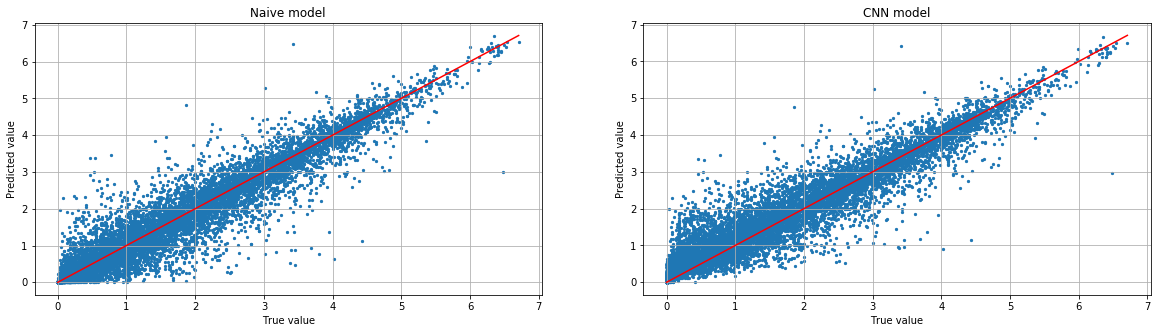

In [476]:
mae_naive = mean_absolute_error(y_true, y_naive)
mae_predict = mean_absolute_error(y_true, y_predict)
r2_naive = explained_variance_score(y_true, y_naive)
r2_predict = explained_variance_score(y_true, y_predict)

print('{}-step MAE [Naive, Ridge Regression] = [{},{}]'.format(
n_days_into_future, mae_naive, mae_predict))
print('{}-step R^2 [Naive, Ridge Regression] = [{},{}]'.format(
n_days_into_future, r2_naive, r2_predict))

true_predict_plot(y_true, y_naive, y_predict, title='')

,new_cases_weighted,new_tests_weighted,new_recovered_weighted,new_deaths_weighted
0,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
20015,0.201844,26.508910,0.807378,0.067281
20016,0.336407,23.683087,0.807378,0.067281
20017,1.816600,37.139387,0.201844,0.067281
20018,0.403689,37.139387,0.134563,0.067281


1-step MAE [Naive, Ridge Regression] = [5.7364545709698405,6.765161436701755]
1-step R^2 [Naive, Ridge Regression] = [0.9434344763263072,0.9259668370886788]


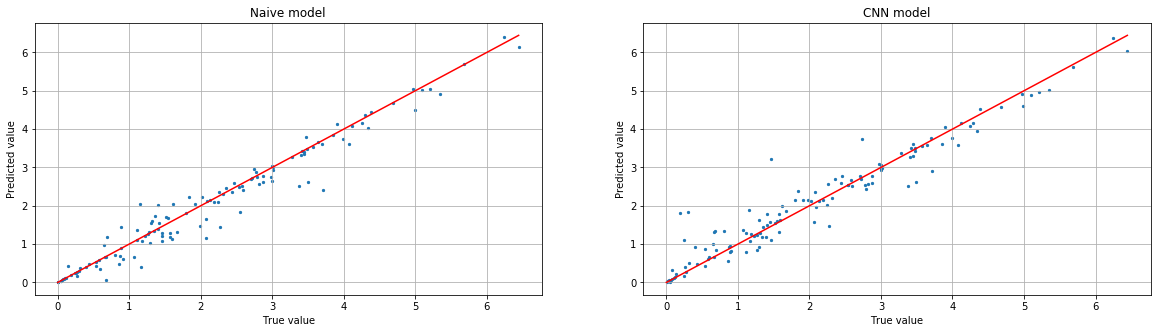

(126,) (126,) (126,)


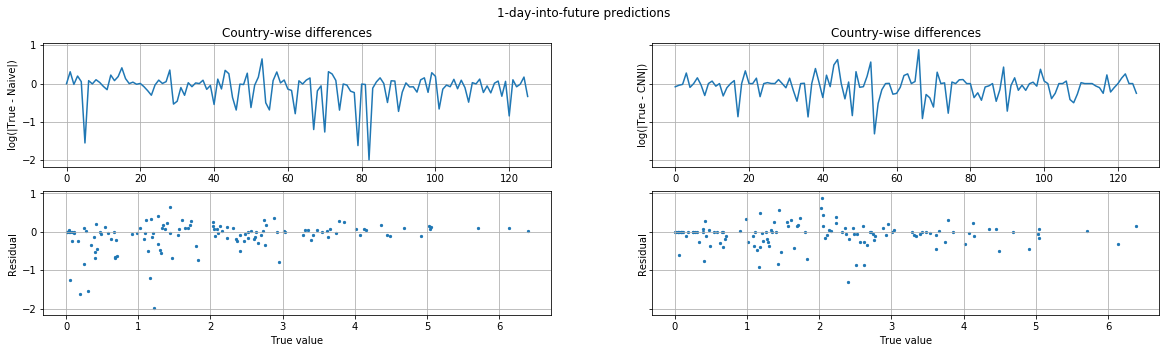

In [468]:
n_test_days = 1
n_days_into_future = 1
model_data = data.drop(columns=data.columns[data.columns.str.contains('flag')])#.drop(columns=data.columns[data.columns.str.contains('mean')])

model_data = data.iloc[:,4:8]
Xs, ys, model =  n_day_forecasting(model_data, n_test_days, n_days_into_future, col_transformer=MinMaxScaler())

y_test, y_naive, y_predict = ys
mae_naive = mean_absolute_error(y_test, y_naive)
mae_predict = mean_absolute_error(y_test, y_predict)
r2_naive = explained_variance_score(y_test, y_naive)
r2_predict = explained_variance_score(y_test, y_predict)

print('{}-step MAE [Naive, Ridge Regression] = [{},{}]'.format(
n_days_into_future, mae_naive, mae_predict))
print('{}-step R^2 [Naive, Ridge Regression] = [{},{}]'.format(
n_days_into_future, r2_naive, r2_predict))

true_predict_plot(y_test, y_naive, y_predict, title='')
residual_diff_plots(y_naive, y_predict, y_test, n_days_into_future, data.location.nunique())
y_predict[y_predict<0]=0


In [220]:
[np.where(y_predict==0)[0]]

[array([111], dtype=int64)]

In [230]:
data[data.time_index==data.time_index.max()].location.iloc[np.where(y_predict==0)].values[0]

'Thailand'

In [239]:
data.location == countries

ValueError: Lengths must match to compare

In [250]:
model.coef_.shape

(44,)

In [260]:
# present_day = data[data.time_index==data.time_index.max()]
# countries=present_day.location.iloc[np.where(y_predict==0)].values
X_test_thai = present_day.loc[present_day.location == 'Thailand',:].drop(columns=data.columns[data.columns.str.contains('flag')]).iloc[:,2:].values
coef = model.coef_
thai_contributions = np.multiply(X_test_thai, coef).ravel()

In [265]:
model_data.iloc[:,2:].columns[np.where(np.abs(thai_contributions)>5)[0]]

Index(['time_index', 'days_since_first_case', 'containment_health_index',
       'government_response_index', 'stringency_index',
       'containment_health_index_rolling_mean_2',
       'government_response_index_rolling_mean_2',
       'stringency_index_rolling_mean_2',
       'containment_health_index_rolling_mean_4',
       'government_response_index_rolling_mean_4',
       'stringency_index_rolling_mean_4',
       'government_response_index_rolling_mean_8',
       'stringency_index_rolling_mean_8',
       'containment_health_index_rolling_mean_16',
       'government_response_index_rolling_mean_16',
       'stringency_index_rolling_mean_16',
       'containment_health_index_rolling_mean_32',
       'government_response_index_rolling_mean_32',
       'stringency_index_rolling_mean_32'],
      dtype='object')

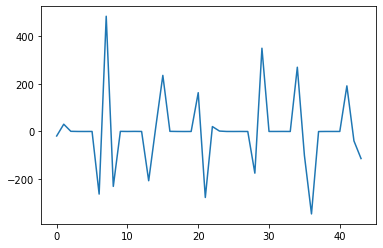

In [255]:
pd.Series(thai_contributions.ravel()).plot()

In [210]:
X_test_japan = data.iloc[:,2:].loc[data[data.time_index==data.time_index.max()].location.index[np.where(y_predict==0)[0]][6],:].values
coef = model.coef_
japan_contributions = np.multiply(X_test_japan, coef)

IndexError: index 6 is out of bounds for axis 0 with size 1

In [211]:
data.columns[np.where(np.abs(japan_contributions)>10)]

Index(['location', 'date', 'new_deaths_weighted_rolling_mean_2',
       'new_tests_weighted_rolling_mean_4',
       'new_recovered_weighted_rolling_mean_4',
       'new_tests_weighted_rolling_mean_8',
       'new_cases_weighted_rolling_mean_32',
       'government_response_index_rolling_mean_32',
       'stringency_index_rolling_mean_32', 'austria_flag', 'burundi_flag',
       'chad_flag', 'chile_flag', 'czechia_flag', 'germany_flag',
       'honduras_flag', 'hungary_flag', 'malawi_flag', 'morocco_flag',
       'mozambique_flag', 'nigeria_flag', 'russia_flag', 'senegal_flag',
       'serbia_flag', 'sierra_leone_flag', 'singapore_flag', 'sri_lanka_flag'],
      dtype='object')

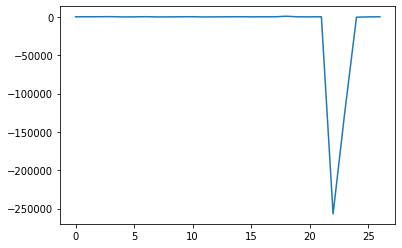

In [165]:
pd.Series(japan_contributions[np.where(np.abs(japan_contributions)>10)]).plot()

In [171]:
np.where(np.abs(japan_contributions)>10)[0][np.argsort(japan_contributions[np.where(np.abs(japan_contributions)>10)])]

array([142, 143, 144,  69,  20,  44, 145,  45, 126,  26,  94,  70,  76,
       120, 114,  51, 151,   0,  95,   1, 139,  89,  14,  64,  39,  19,
       119], dtype=int64)

array([22, 23, 24, 11,  4,  7, 25,  8, 20,  5, 15, 12, 13, 19, 17,  9, 26,
        0, 16,  1, 21, 14,  2, 10,  6,  3, 18], dtype=int64)

In [164]:
data.columns[np.where(np.abs(japan_contributions)>10)]

Index(['location', 'date', 'c7_restrictions_on_internal_movement',
       'e3_fiscal_measures', 'e4_international_support',
       'h4_emergency_investment_in_healthcare',
       'c7_restrictions_on_internal_movement_rolling_mean_2',
       'e3_fiscal_measures_rolling_mean_2',
       'e4_international_support_rolling_mean_2',
       'h4_emergency_investment_in_healthcare_rolling_mean_2',
       'c7_restrictions_on_internal_movement_rolling_mean_4',
       'e3_fiscal_measures_rolling_mean_4',
       'e4_international_support_rolling_mean_4',
       'h4_emergency_investment_in_healthcare_rolling_mean_4',
       'c7_restrictions_on_internal_movement_rolling_mean_8',
       'e3_fiscal_measures_rolling_mean_8',
       'e4_international_support_rolling_mean_8',
       'c7_restrictions_on_internal_movement_rolling_mean_16',
       'e3_fiscal_measures_rolling_mean_16',
       'e4_international_support_rolling_mean_16',
       'h4_emergency_investment_in_healthcare_rolling_mean_16',
       'c7_

In [179]:
data[data.location=='Japan']

,location,date,time_index,days_since_first_case,new_cases_weighted,new_tests_weighted,new_recovered_weighted,new_deaths_weighted,c1_school_closing,c2_workplace_closing,...,aged_65_older_missing_flag,aged_70_older_missing_flag,gdp_per_capita_missing_flag,extreme_poverty_missing_flag,cvd_death_rate_missing_flag,diabetes_prevalence_missing_flag,female_smokers_missing_flag,male_smokers_missing_flag,handwashing_facilities_missing_flag,hospital_beds_per_thousand_missing_flag
9724,Japan,2020-01-22,0,0,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
9725,Japan,2020-01-23,1,1,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
9726,Japan,2020-01-24,2,2,0.007907,0.0,0.000000,0.000000,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
9727,Japan,2020-01-25,3,3,0.007907,0.0,0.000000,0.000000,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
9728,Japan,2020-01-26,4,4,0.007907,0.0,0.007907,0.000000,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9862,Japan,2020-06-08,138,138,0.260918,0.0,0.419050,0.015813,3.0,0.0,...,0,0,0,1,0,0,0,0,1,0
9863,Japan,2020-06-09,139,139,0.284638,0.0,0.774848,0.015813,3.0,0.0,...,0,0,0,1,0,0,0,0,1,0
9864,Japan,2020-06-10,140,140,0.324171,0.0,0.600902,0.023720,3.0,0.0,...,0,0,0,1,0,0,0,0,1,0
9865,Japan,2020-06-11,141,141,0.324171,0.0,0.126506,0.007907,3.0,0.0,...,0,0,0,1,0,0,0,0,1,0


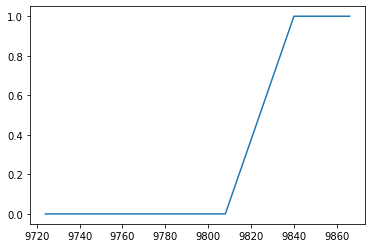

In [178]:
data[data.location=='Japan'].e1_income_support_rolling_mean_32.plot()

In [180]:
# np.argsort(japan_contributions[np.where(np.abs(japan_contributions)>10)])
# worst offending columns
worst_columns_args = np.where(np.abs(japan_contributions)>10)[0][np.argsort(japan_contributions[np.where(np.abs(japan_contributions)>10)])]
worst_columns = data.columns[worst_columns_args]

In [183]:
X_test.shape

(126, 309)

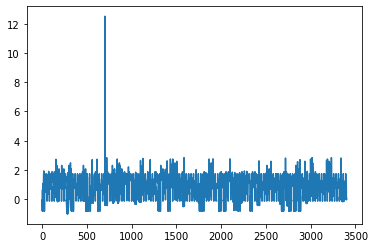

In [185]:
pd.Series(X_test[:, worst_columns_args].ravel()).plot()

In [141]:
np.where(y_predict==0)[0]

array([  3,  17,  18,  19,  26,  30,  58,  64,  65,  69,  75,  76,  80,
        86,  95, 111, 112, 124, 125], dtype=int64)

In [134]:
data.location.unique()[np.where(y_predict==0)[0]]

array(['Angola', 'Bulgaria', 'Burkina Faso', 'Burundi', 'China', 'Cuba',
       'Japan', 'Lesotho', 'Liberia', 'Malawi', 'Mozambique', 'Namibia',
       'Niger', 'Papua New Guinea', 'Rwanda', 'Thailand',
       'Trinidad And Tobago', 'Zambia', 'Zimbabwe'], dtype=object)

In [102]:
data.location.unique()[np.where(y_test==0)[0]]

array(['Benin', 'Botswana', 'Cambodia', 'Cameroon', 'Colombia', 'Croatia',
       'Ecuador', 'Eritrea', 'Ghana', 'Lesotho', 'Mauritania', 'Namibia',
       'New Zealand', 'Niger', 'Papua New Guinea', 'Slovenia',
       'South Sudan', 'Spain', 'Thailand', 'Trinidad And Tobago',
       'Tunisia', 'Uruguay', 'Vietnam', 'Zambia'], dtype=object)

In [117]:
np.where(y_predict==0)[0]

array([  3,  17,  19,  30,  32,  58,  64,  65,  76,  80,  95, 106, 111,
       120, 124], dtype=int64)

What we talked about: do not use 0, fill with previous day's values. 

In [121]:
y_test

17766    19.189104
17767    15.289457
17768     2.394470
17769     0.152132
17770    30.378944
           ...    
17887     3.704899
17888     2.672674
17889     0.000000
17890     0.000000
17891     0.807378
Name: new_cases_weighted, Length: 126, dtype: float64

In [ ]:
np.where(y_predict==0)[0]

In [103]:
y_predict[y_predict==0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

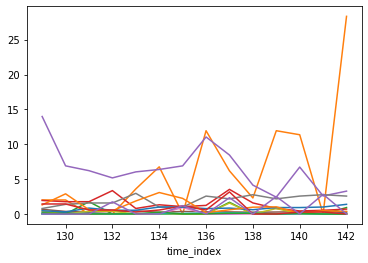

In [104]:
predict_zeros = data[data.location.isin(data.location.unique()[np.where(y_predict==0)[0]])]
predict_zeros[predict_zeros.time_index > 128].set_index(['time_index', 'location']).new_cases_weighted.unstack().plot(legend=False)

In [105]:
data[data.location.isin(data.location.unique()[np.where(y_predict==0)[0]])].set_index(['time_index', 'location'])

,,date,days_since_first_case,new_cases_weighted,new_tests_weighted,new_recovered_weighted,new_deaths_weighted,c1_school_closing,c2_workplace_closing,c3_cancel_public_events,c4_restrictions_on_gatherings,...,aged_65_older_missing_flag,aged_70_older_missing_flag,gdp_per_capita_missing_flag,extreme_poverty_missing_flag,cvd_death_rate_missing_flag,diabetes_prevalence_missing_flag,female_smokers_missing_flag,male_smokers_missing_flag,handwashing_facilities_missing_flag,hospital_beds_per_thousand_missing_flag
time_index,location,,,,,,,,,,,,,,,,,,,,,
0,Angola,2020-01-22,0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
1,Angola,2020-01-23,0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
2,Angola,2020-01-24,0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
3,Angola,2020-01-25,0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
4,Angola,2020-01-26,0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,Zambia,2020-06-08,82,0.000000,0.0,0.000000,0.000000,3.0,2.0,0.0,3.0,...,0,0,0,0,0,0,0,0,0,0
139,Zambia,2020-06-09,83,2.502182,0.0,0.000000,0.163186,3.0,2.0,0.0,3.0,...,0,0,0,0,0,0,0,0,0,0
140,Zambia,2020-06-10,84,0.000000,0.0,0.000000,0.000000,3.0,2.0,0.0,3.0,...,0,0,0,0,0,0,0,0,0,0


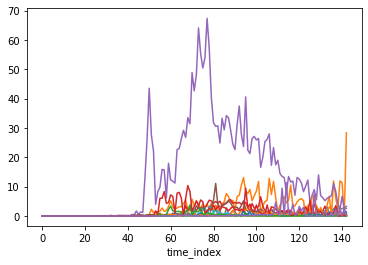

In [106]:
data[data.location.isin(data.location.unique()[np.where(y_predict==0)[0]])].set_index(['time_index', 'location']).new_cases_weighted.unstack().plot(legend=False)

In [151]:
coefarg = np.argsort(np.abs(coef))[::-1]

In [152]:
coef[coefarg]

array([ 2.24625337e+01,  9.52877375e+00, -7.43568207e+00,  6.68537755e+00,
       -5.82199554e+00, -4.94514358e+00,  4.44578400e+00, -4.40159454e+00,
       -4.37375828e+00,  4.27296817e+00,  4.21178824e+00,  4.18762700e+00,
        4.18039943e+00, -4.13008529e+00,  3.78896522e+00, -3.65301730e+00,
        3.64391341e+00,  3.63870993e+00,  3.39555078e+00,  3.36142961e+00,
        2.93914884e+00,  2.91719261e+00,  2.90384983e+00, -2.86941712e+00,
       -2.62542896e+00, -2.62459730e+00, -2.62158158e+00, -2.53775932e+00,
        2.43591553e+00,  2.43223146e+00, -2.34546261e+00,  2.33939526e+00,
       -2.29378381e+00, -2.26023740e+00,  2.07258693e+00, -2.03544989e+00,
       -1.84153482e+00, -1.76220159e+00,  1.63588204e+00, -1.48261489e+00,
        1.42830785e+00, -1.42437979e+00, -1.40055067e+00,  1.35310811e+00,
       -1.33541281e+00,  1.31550253e+00, -1.31041074e+00,  1.25710601e+00,
        1.22015910e+00,  1.19859677e+00,  1.17621262e+00,  1.12226738e+00,
       -1.10853931e+00,  

In [109]:
data.iloc[:, 2:].columns[coefarg]

Index(['new_cases_weighted_rolling_mean_8',
       'economic_support_index_rolling_mean_16',
       'containment_health_index_rolling_mean_2',
       'new_cases_weighted_rolling_mean_4',
       'new_tests_weighted_rolling_mean_16',
       'economic_support_index_rolling_mean_32',
       'e1_income_support_rolling_mean_16',
       'e2_debt_contract_relief_rolling_mean_16', 'government_response_index',
       'new_cases_weighted_rolling_mean_16',
       ...
       'united_states_flag', 'costa_rica_flag', 'uganda_flag',
       'h5_investment_in_vaccines_rolling_mean_16',
       'e4_international_support_rolling_mean_4', 'ivory_coast_flag',
       'rwanda_flag', 'chad_flag', 'liberia_flag',
       'e4_international_support_rolling_mean_2'],
      dtype='object', length=309)

In [110]:
data.loc[:, column_search(data, 'missing')].sum()

c1_school_closing_missing_flag                          537
c2_workplace_closing_missing_flag                       570
c3_cancel_public_events_missing_flag                    563
c4_restrictions_on_gatherings_missing_flag              557
c5_close_public_transport_missing_flag                  564
c6_stay_at_home_requirements_missing_flag               537
c7_restrictions_on_internal_movement_missing_flag       542
c8_international_travel_controls_missing_flag           536
containment_health_index_missing_flag                   561
e1_income_support_missing_flag                          526
e2_debt_contract_relief_missing_flag                    542
e3_fiscal_measures_missing_flag                         711
e4_international_support_missing_flag                   566
economic_support_index_missing_flag                     575
government_response_index_missing_flag                  564
h1_public_information_campaigns_missing_flag            539
h2_testing_policy_missing_flag          

In [94]:
(data==0).sum().sort_values()

location                                       0
date                                           0
time_index                                   126
government_response_index                   2039
containment_health_index                    2039
                                           ...  
guinea_bissau_flag                         17875
algeria_flag                               17875
h5_investment_in_vaccines                  17910
e4_international_support_rolling_mean_2    17910
e4_international_support                   17959
Length: 311, dtype: int64

In [87]:
coef.size

309

In [79]:
coef[::-1]

array([ 43, 118, 193, 216, 264, 270, 232,  68, 125, 175, 202, 260, 150,
       231, 266, 160, 249, 179, 208, 238,  18, 251, 186, 170, 198, 222,
       308, 189, 165, 258, 223, 253, 212, 203, 273, 246, 196, 172, 241,
       174, 228, 187, 197, 188, 173, 190, 247, 240, 250, 235, 182, 169,
       272, 214, 209, 287, 215, 199, 255, 207, 154, 181, 263, 233, 158,
       254, 271, 229, 275, 276, 245, 191, 117, 213, 135,  25, 265, 217,
       195, 261, 178,  88, 156, 205,  50, 268,  74, 242, 184, 164, 252,
       237, 225, 248, 227, 220,  17,  93, 153, 286, 262, 274, 201, 161,
       155, 219, 296, 244, 269, 257, 100, 224,   0, 143, 211, 221, 194,
       166, 138, 183, 168, 210, 142, 204, 152, 218, 292, 157, 300, 163,
       226,  42, 192, 113, 283,  65, 267, 180, 206, 200, 234, 185, 259,
       239, 124,  67, 236,  92,  75, 302, 167, 230,   4,  24, 290, 109,
        57, 162, 256,  54, 177, 159, 279,  99, 291, 301, 107, 285, 129,
       146, 295,   1, 289,  49, 293, 307, 132, 136, 149, 176, 11

In [ ]:
n_test_days = 1
n_days_into_future = 7
ys, model =  n_day_forecasting(model_data, n_test_days, n_days_into_future)


y_test, y_naive, y_predict = ys
y_predict[y_predict<0]=0
mae_naive = mean_absolute_error(y_test, y_naive)
mae_predict = mean_absolute_error(y_test, y_predict)
r2_naive = explained_variance_score(y_test, y_naive)
r2_predict = explained_variance_score(y_test, y_predict)

print('{}-step MAE [Naive, CNN] = [{},{}]'.format(
n_days_into_future, mae_naive, mae_predict))
print('{}-step R^2 [Naive, CNN] = [{},{}]'.format(
n_days_into_future, r2_naive, r2_predict))

true_predict_plot(y_test, y_naive, y_predict, title='')
residual_diff_plots(y_naive, y_predict, y_test, n_days_into_future, data.location.nunique())

In [ ]:
n_test_days = 1
n_days_into_future = 14
ys, model =  n_day_forecasting(model_data, n_test_days, n_days_into_future)

y_test, y_naive, y_predict = ys
y_predict[y_predict<0]=0
mae_naive = mean_absolute_error(y_test, y_naive)
mae_predict = mean_absolute_error(y_test, y_predict)
r2_naive = explained_variance_score(y_test, y_naive)
r2_predict = explained_variance_score(y_test, y_predict)

print('{}-step MAE [Naive, CNN] = [{},{}]'.format(
n_days_into_future, mae_naive, mae_predict))
print('{}-step R^2 [Naive, CNN] = [{},{}]'.format(
n_days_into_future, r2_naive, r2_predict))

true_predict_plot(y_test, y_naive, y_predict, title='')
residual_diff_plots(y_naive, y_predict, y_test, n_days_into_future, data.location.nunique())

Always seems to be an outliers > 200, see which countries these belong to.

There are 7 values greater than 300 which clearly stand out as separated from the rest of the values.
Let's check if there is anything in common between these points. Using numpy to find the indices at which
the values occur to figure out the countries the values come from.

It turns out all of these large values come from Qatar, let's look at the time series with true and predicted values to see if we can understand what is going on, i.e. why the large values are being underestimated.

In [ ]:
rm14_time_series = X.loc[:, ['location','date','new_cases_per_million_rolling_mean_14']].set_index(['location', 'date']).unstack()
rm14_time_series.columns = np.array(list(range(len(rm14_time_series.columns))))
rm14_time_series = rm14_time_series.loc[:, 15:]
rm14_prediction_series = rm14_time_series.copy()

baseline_time_series = X.loc[:, ['location','date','new_cases_per_million_rolling_mean_14']].set_index(['location', 'date']).unstack()
baseline_time_series.columns = np.array(list(range(len(baseline_time_series.columns))))
baseline_time_series = baseline_time_series.shift(14, axis=1).loc[:, 15:]
# baseline_time_series = baseline_time_series.dropna(axis=1)


In [ ]:
rm14_prediction_series.iloc[:, -(shift):] = predictions

In [ ]:
def plot_prediction_versus_truth_time_series(country_index, shift, truth_time_series, prediction_time_series):
    plt.figure(figsize=(5,5))
    plt.plot(truth_time_series.columns[:-(shift+1)], truth_time_series.iloc[country_index,:-(shift+1)], label='True past')
    plt.plot(truth_time_series.columns[-(shift+1):], truth_time_series.iloc[country_index,-(shift+1):], label='True future')
    plt.plot(truth_time_series.columns[-(shift+1):], prediction_time_series.iloc[country_index, -(shift+1):], label='Predicted future', linestyle='--')
    plt.legend(loc=(1,0.5))
    plt.show()
    return None

In [ ]:
X[X.location=='Afghanistan'].loc[:, ['new_cases_per_million', 'new_cases_per_million_rolling_mean_3', 'new_cases_per_million_rolling_mean_7', 'new_cases_per_million_rolling_mean_14']].plot()

In [ ]:
rm14_time_series.iloc[0,:].plot()
n_cases_time_series.iloc[0,:].plot()

In [ ]:
shift = 14
for country_index in range(rm14_time_series.shape[0]):
    plot_prediction_versus_truth_time_series(country_index, shift, rm14_time_series, rm14_prediction_series)

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(n_cases_time_series.columns[:-7], n_cases_time_series.iloc[92,:-7], label='True past')
plt.plot(n_cases_time_series.columns[-8:], np.concatenate(([n_cases_time_series.iloc[92,-8]],truths[92, :])), label='True future')
plt.plot(n_cases_time_series.columns[-8:], np.concatenate(([n_cases_time_series.iloc[92,-8]],predictions[92, :])), label='Predicted future', linestyle='--')
plt.legend(loc=(1,0.5))
plt.show()

In [ ]:
plt.plot(np.abs(truths_no_q[:,0] - predictions_no_q[:,0]))

In [ ]:
np.where(np.abs(truths_no_q - predictions_no_q) > 60)

In [ ]:
n_cases_time_series.iloc[[8,27,37],:]

In [ ]:
truths_no_outliers = np.delete(truths, [8,27,37,92], axis=0)
predictions_no_outliers = np.delete(predictions, [8,27,37,92], axis=0)

fig, ax = plt.subplots(figsize=(10,10))
for c in range(truths_no_outliers.shape[1]):
    ax.scatter(truths_no_outliers.shape[0]*[c], 
               truths_no_outliers[:, c] - predictions_no_outliers[:, c], label=str(c+1), s=25, alpha=0.5)
    plt.legend()
ax.axhline(0, xmin=0, xmax=500, color='r')
plt.show()

Because all of the outlier values of n_cases_per_million belong to Qatar, let's see how we perform when we drop
them from the modeling process.

In [ ]:
n_step_models = []
n_step_mse = []
X_no_qatar = X[X.location != 'Qatar']
for shift in range(1, 8):
    y = shift_for_forecasting(X_no_qatar, forecast_interval=shift, target_name='new_cases_per_million').dropna()
    X_model = X_no_qatar.loc[y.index,:]
    
    # time index, the quantity which tracks days since first case, is still in X.
    # X_train =  X[X.date_proxy < day].drop(columns=['location','date'])
    # X_test = X[X.date_proxy == day].drop(columns=['location','date'])
    
    X_train =  X_model[X_model.date_proxy <= prediction_date - shift].drop(columns=['location','date','date_proxy', 'time_index'])
    X_test = X_model[X_model.date_proxy == prediction_date].drop(columns=['location','date','date_proxy', 'time_index'])

    y_train = y.loc[X_train.index].values.ravel()
    y_test = y.loc[X_test.index].values.ravel()

    col_transformer = StandardScaler()
    _ = col_transformer.fit(X_train)
    X_train_normalized =  col_transformer.transform(X_train)
    X_test_normalized =  col_transformer.transform(X_test)

#     pca = PCA(n_components=25)
#     _ = pca.fit(X_train_normalized)
#     X_train_normalized = pca.transform(X_train_normalized)
#     X_test_normalized = pca.transform(X_test_normalized)

    r = Ridge() 
    _ = r.fit(X_train_normalized, y_train)
    n_step_models.append([r])
    y_true, y_predict, mse = classifier_analysis(r, X_test_normalized, y_test, plot=False, metric='mae')
    n_step_mse.append(mse)
    if shift == 1:
        true_predict_array = np.concatenate((y_true.reshape(-1,1), y_predict.reshape(-1,1)), axis=1)
    else:
        true_predict_array = np.concatenate((true_predict_array, y_true.reshape(-1,1), y_predict.reshape(-1,1)), axis=1)
    print('#', end='')
    
# correspond to n+1, n+2, ... n+7 predictions and truths. 109-115
predictions = true_predict_array[:, 1::2]#.ravel()
truths = true_predict_array[:, ::2]#.ravel()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(truths.ravel(), predictions.ravel(), s=5)
plt.plot([0,500], [0,500], color='r')
plt.show()

print(explained_variance_score(truths.ravel(), predictions.ravel()))
print(mean_absolute_error(truths.ravel(), predictions.ravel()))
print(mean_squared_error(truths.ravel(), predictions.ravel()))

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [ ]:
plt.matshow(pd.DataFrame(truths-predictions).corr())
plt.colorbar()
np.set_printoptions(precision=3)
print(np.matrix(pd.DataFrame(truths-predictions).corr()))

In [ ]:
_ = pd.plotting.scatter_matrix(pd.DataFrame(truths-predictions), figsize=(10,10))

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
for c in range(truths.shape[1]):
    ax.scatter(truths[:, c], truths[:, c] - predictions[:, c], label=str(c+1), s=25, alpha=0.5)
    plt.legend()
# plt.plot([0,500], [0,500], color='r')
ax.axhline(0, xmin=0, xmax=500, color='r')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(n_cases_time_series.columns[:-7], n_cases_time_series.iloc[-7,:-7], label='True past')
plt.plot(n_cases_time_series.columns[-7:], truths[-7, :], label='True future')
plt.plot(n_cases_time_series.columns[-7:], predictions[-7, :], label='Predicted future')
plt.legend(loc=(1,0.5))
plt.show()

To predict a week into the future means that I can only compare values for day 9 (indexed as 8), because I want to avoid using a single data point to train as this causes issues. Therefore I am predicting days indexed from 8-115; days 9 through 116. 

## rolling mean prediction, need to shift even futher back right?

In [ ]:
n_step_models = []
n_step_mse = []
for shift in range(1, 15):
    y = shift_for_forecasting(X, forecast_interval=shift, target_name='new_cases_per_million_rolling_mean_14').dropna()
    X_model = X.loc[y.index,:]

    # time index, the quantity which tracks days since first case, is still in X.
    # X_train =  X[X.date_proxy < day].drop(columns=['location','date'])
    # X_test = X[X.date_proxy == day].drop(columns=['location','date'])
    
    X_train =  X_model[X_model.date_proxy <= prediction_date - shift].drop(columns=['location','date','date_proxy', 'time_index'])
    X_test = X_model[X_model.date_proxy == prediction_date].drop(columns=['location','date','date_proxy', 'time_index'])

    y_train = y.loc[X_train.index].values.ravel()
    y_test = y.loc[X_test.index].values.ravel()

    col_transformer = StandardScaler()
    _ = col_transformer.fit(X_train)
    X_train_normalized =  col_transformer.transform(X_train)
    X_test_normalized =  col_transformer.transform(X_test)

#     pca = PCA(n_components=25)
#     _ = pca.fit(X_train_normalized)
#     X_train_normalized = pca.transform(X_train_normalized)
#     X_test_normalized = pca.transform(X_test_normalized)

    r = Ridge() 
    _ = r.fit(X_train_normalized, y_train)
    n_step_models.append([r])
    y_true, y_predict, mse = classifier_analysis(r, X_test_normalized, y_test, plot=False, metric='mae')
    n_step_mse.append(mse)
    if shift == 1:
        true_predict_array = np.concatenate((y_true.reshape(-1,1), y_predict.reshape(-1,1)), axis=1)
    else:
        true_predict_array = np.concatenate((true_predict_array, y_true.reshape(-1,1), y_predict.reshape(-1,1)), axis=1)
    print('#', end='')

# correspond to n+1, n+2, ... n+7 predictions and truths. 109-115
predictions = true_predict_array[:, 1::2]#.ravel()
truths = true_predict_array[:, ::2]#.ravel()

Using a naive baseline, which would be a constant number of new cases per day; this means the value for the prediction 7 days into the future is simply the value from 7 days ago. 

In [ ]:
# explained_variance_scores = []
for day in X.date_proxy.unique()[1:]:
    # time index, the quantity which tracks days since first case, is still in X.
    X_train =  X[X.date_proxy < day].drop(columns=['location','date'])
    X_test = X[X.date_proxy == day].drop(columns=['location','date'])
#     X_train =  X[X.date_proxy < day].drop(columns=['location','date','date_proxy', 'time_index'])
#     X_test = X[X.date_proxy == day].drop(columns=['location','date','date_proxy', 'time_index'])
    y_train = y.loc[X_train.index].values.ravel()
    y_test = y.loc[X_test.index].values.ravel()
    
    col_transformer = StandardScaler()
    _ = col_transformer.fit(X_train)
    X_train_normalized =  col_transformer.transform(X_train)
    X_test_normalized =  col_transformer.transform(X_test)
    
#     pca = PCA(n_components=10)
#     _ = pca.fit(X_train_normalized)
#     X_train_normalized_pca = pca.transform(X_train_normalized)
#     X_test_normalized_pca = pca.transform(X_test_normalized)
    
    r = Ridge() 
    _ = r.fit(X_train_normalized, y_train)
    y_true, y_predict, evs = classifier_analysis(r, X_test_normalized, y_test, plot=False)
    n_cases_prediction_series.loc[:, day+7] = y_predict
    print('#', end='')

In [ ]:
# evs_scores = []
# baseline_evs_scores = []
# for c in n_cases_time_series.columns:
#     evs_scores.append(explained_variance_score(n_cases_time_series.loc[:, c].values, 
#                                                n_cases_prediction_series.loc[:, c].values))
#     baseline_evs_scores.append(explained_variance_score(n_cases_time_series.loc[:, c].values,
#                                                         baseline_time_series.loc[:, c].values))

# evs_scores = np.array(evs_scores)
# baseline_evs_scores = np.array(baseline_evs_scores)

In [ ]:
# fig, ax = plt.subplots()
# ax.set_title('Difference in explained variance')
# ax.plot(evs_scores, marker='.', linestyle='none')
# ax.plot(baseline_evs_scores, marker='.', linestyle='none')
# ax.set_ylabel('$R^2$ model - $R^2$ baseline')
# ax.axhline(0, xmin=0, xmax=150, color='r')
# ax.set_ylim([-1.05,1.05])

In [ ]:
# explained_variance_scores = []
for day in X.date_proxy.unique()[1:]:
    # time index, the quantity which tracks days since first case, is still in X.
    X_train =  X[X.date_proxy < day].drop(columns=['location','date'])
    X_test = X[X.date_proxy == day].drop(columns=['location','date'])
#     X_train =  X[X.date_proxy < day].drop(columns=['location','date','date_proxy', 'time_index'])
#     X_test = X[X.date_proxy == day].drop(columns=['location','date','date_proxy', 'time_index'])
    y_train = y.loc[X_train.index]#.values.ravel()
    y_test = y.loc[X_test.index]#.values.ravel()

    for country_indices in country_groupby_indices_list(X):

        X_train_country =  X_train.loc[X_train.index.intersection(country_indices), :]
        X_test_country = X_test.loc[X_test.index.intersection(country_indices), :]
        y_train_country = y_train.loc[X_train_country.index].values.ravel()
        y_test_country = y_test.loc[X_test_country.index].values.ravel()
        
        transformer = StandardScaler()
        _ = transformer.fit(X_train_country)
        X_train_normalized = transformer.transform(X_train_country)
        X_test_normalized = transformer.transform(X_test_country)
        
        r = Ridge() 
        _ = r.fit(X_train_normalized, y_train_country)
        
#         y_true0, y_predict0, mse0 = classifier_analysis(r, X_train_normalized, y_train_country,  metric='mse', plot=False)
        y_true, y_predict, mse = classifier_analysis(r, X_test_normalized, y_test_country, metric='mse', plot=False)
        
#         n_cases_predict_time_series_df.loc[
#             X.loc[country_indices,:].location.unique()[0], n_cases_predict_time_series_df.columns[1]:day] = y_predict0
    
        n_cases_prediction_series.loc[
            X.loc[country_indices,:].location.unique()[0], day+7] = y_predict
#         country_mse.append(mse)
#     explained_variance_scores.append(evs)
    print('#',end='')
# explained_variance_scores = np.array(explained_variance_scores)

Previously made what I believe is a mistake or the wrong thing to do,
which was to compute the time series of explained variance scores; i.e. I take the predictions
for a certain date for all countries and compare that to the real value on that date, for all
countries. I think its wiser to compute the EVS for each country as this is more indicative of
whether the trend is being captured or not??

Because this is n cases and not n cases change, use naive forecasting model, i.e. predicted value is value from 7 days prior.

There seems to be a bias to underestimate larger values.

# 7-day forecast via single step propagating model.

target variable construction should be the same

Given a matrix of all drifts, (rows are countries and columns are features), the values 

Drift features are the numerical time dependent features, not including the rolling means, time indices
are special.
They do not need to be recomputed as they are in X_test. 

Rolling means will be recomputed to incoporate simple forecasting; instead of just simple forecasting the rolling means themselves.

Naive features are 

In [ ]:
drift_features = model_data.loc[:, :'time_index'].iloc[:, :-2].columns.tolist()

naive_features = (time_independent.columns.tolist() 
                  + location_one_hot.columns.tolist()
                  +tests_units_one_hot.columns.tolist()
                  + flag_and_misc.columns.tolist()[:-2])

X_model = X#.drop(columns=['location', 'date'])
X_train = X_model[X_model.date_proxy < X_model.date_proxy.max()-8]
X_test = X_model[(X_model.date_proxy >= X_model.date_proxy.max()-7) & (X_model.date_proxy < X_model.date_proxy.max())]

X_test_simple_model_forecasting = simple_model_forecast(X_train, drift_features, naive_features, forecast_interval=7)

In [ ]:
X_model = X#.drop(columns=['location', 'date'])
X_train = X_model[X_model.date_proxy < X_model.date_proxy.max()-8]
X_test = X_model[(X_model.date_proxy >= X_model.date_proxy.max()-7) & (X_model.date_proxy < X_model.date_proxy.max())]

In [ ]:
X_test_simple_model_forecasting = simple_model_forecast(X_train, drift_features, naive_features, forecast_interval=7)

To compute new rolling means, take new drift feature values, concatenate with those in training, and then roll.
Need to reintroduce indexes however to sort the values correctly. 

In [ ]:
X_forecasted = X.copy().drop(columns=rolling_predictors.columns)
X_forecasted.loc[X_test.index, :].iloc[:, 2:-2] = X_test_simple_model_forecasting.values

In [ ]:
rolling_predictors_forecasted = rolling_features(X_forecasted, pd.Index(drift_features), roll_widths)

In [ ]:
Xf = pd.concat((X_forecasted.loc[:, :drift_features[-1]], 
                           rolling_predictors_forecasted, 
                           X_forecasted.loc[:, naive_features[0]:],),axis=1)
Xf = X.loc[:, Xf.columns[~Xf.columns.str.contains('new_cases')]]

In [ ]:
X_model = Xf.drop(columns=['location', 'date'])
X_train = X_model[X_model.date_proxy < X_model.date_proxy.max()-8]
X_test = X_model[(X_model.date_proxy >= X_model.date_proxy.max()-7) & (X_model.date_proxy < X_model.date_proxy.max())]

In [ ]:
y = shift_for_forecasting(model_data)
y_train = y.loc[X_train.index].values.ravel()
y_test = y.loc[X_test.index].values.ravel()

baseline_time_series

In [ ]:
n_cases_prediction_series_propagate = n_cases_time_series.copy()

In [ ]:
n_cases_prediction_series_propagate.iloc[:, -7:] = y_predict.reshape(126, 7)

In [ ]:
col_transformer = StandardScaler()
_ = col_transformer.fit(X_train)
X_train_normalized =  col_transformer.transform(X_train)
X_test_normalized =  col_transformer.transform(X_test)

r = Ridge() 
_ = r.fit(X_train_normalized, y_train)
y_true, y_predict, evs = classifier_analysis(r, X_test_normalized, y_test)

In [ ]:
plt.scatter(y_true, y_true-y_predict)
plt.show()

In [ ]:
mse = explained_variance_score(y_true, y_predict)
evs = mean_squared_error(y_true, y_predict)

print('Mean squared error {}'.format(mse))
print('Explained variance score {}'.format(evs))

In [ ]:
time_dependent= model_data.set_index('location').loc[:, :'time_index'].iloc[:, :-2].reset_index()
time_independent = model_data.loc[:, 'time_index':'cvd_death_rate'].iloc[:, 1:].fillna(0)#.columns
flag_and_misc = model_data.loc[:, 'c1_flag_0':'date']

In [ ]:
# This drops the first category, Afghanistan.
location_one_hot = pd.get_dummies(model_data.loc[:, 'location'], drop_first=True)
# this specifically drops the NaN category
tests_units_one_hot = pd.get_dummies(model_data.loc[:, 'tests_units'])
tests_units_one_hot.columns = 'test_units_' + reformat_values(tests_units_one_hot, category='columns')

In [ ]:
X = pd.concat((model_data.loc[:, 'date_proxy':'time_index'], time_dependent.drop(columns='location'), 
                rolling_predictors, time_independent,
                   location_one_hot, tests_units_one_hot, flag_and_misc),axis=1)

In [ ]:
X_test_propagation_model = X[X.date_proxy >= X.date_proxy.max()-7]

In [ ]:
naive_features = location_one_hot.columns.append(tests_units_one_hot.columns).append(flag_and_misc.columns)[:-2]

In [ ]:
drift_features = X.iloc[:,2:].columns.difference(naive_features)

In [ ]:
drift_features = time_dependent.drop(columns='location').columns
naive_features = time_independent.columns.append(flag_and_misc.iloc[:,:-2].columns)

In [ ]:
X_train_propagation_model = X[X.date_proxy < X.date_proxy.max()-7]

simple_forecast_features = pd.Index(['date_proxy', 'time_index']).append(drift_features.append(naive_features))
X_train_propagation_model = X[X.date_proxy < X.date_proxy.max()-7].loc[:, simple_forecast_features]

I don't think its unfair to compute simple forecasts and then their rolling means, instead of just simple
forecasting their values. Might not be different actually

In [ ]:
explained_variance_scores = []
for day in X.date_proxy.unique()[1:-7]:
    # time index, the quantity which tracks days since first case, is still in X.
    X_train =  X[X.date_proxy < day].drop(columns=['location','date','date_proxy', 'time_index'])
    X_test = X[X.date_proxy == day].drop(columns=['location','date','date_proxy', 'time_index'])
    y_train = y.loc[X_train.index].values.ravel()
    y_test = y.loc[X_test.index].values.ravel()
    
    col_transformer = StandardScaler()
    _ = col_transformer.fit(X_train)
    X_train_normalized =  col_transformer.transform(X_train)
    X_test_normalized =  col_transformer.transform(X_test)

    r = Ridge() 
    _ = r.fit(X_train_normalized, y_train)
    y_true, y_predict, evs = classifier_analysis(r, X_test_normalized, y_test, plot=False)
    n_cases_prediction_series.loc[:, day+7] = y_predict
    explained_variance_scores.append(evs)
    print('#',end='')
explained_variance_scores = np.array(explained_variance_scores)

# COVID-19 Case number modeling with no new features.
<a id='model'></a>
[Return to table of contents](#toc)

The first segment of the modeling process takes the "original" data, reformatted as per the
data cleaning notebook and then performs the necessary operations to encode the categorical variables.
The target variable is assigned to be the number of cases and the pipeline for the modeling process is as
follows (current iteration):
    
    1. Encode data, split into feature and target data.
    2. Create cross validation folds; split into train-test and holdout data sets. 
    2. Normalize the feature data via sklearn's StandardScaler. 
    3. Perform PCA on the normalized feature data
    4. Apply Ridge regression on the normalized, PCA transformed data. 

# Single step predictions

Need location for groupby indices, but date and date proxy I do not think are useful currently. 

In [ ]:
X_tmp = model_data.copy()#.drop(columns=['date','date_proxy'])
y_tmp = X_tmp.new_cases_per_million

Create cross validation folds which respect the time-series dates.

Instead of flailing about let's actually type out how to do this.

Steps that need to be completed.

    Target variable shifting.
    CV folds
    Feature encoding
    

Get the indices which correspond to each country, prior to shifting the target variable time series.
Assign target and feature variable arrays prior to shifting the target variable.
I don't think dropping the case data is actually necessary so long as the time series aspect is respected.
Get the data ready for training

Collect the indices which correspond to each country.

Shift the target variable by one so that the feature data up until day n-1 is predicting the target variable at day n.
In other words, train on data which is up to but not including the date of prediction. 

What Mike said:

X_train ......................................... y_train

DATA UP TO AND INCLUDING 2020-05-01 ............. TARGET ON 2020-05-02

This does not predict the first day and does not include the data on the last day. 
Therefore the correct operation is to group by country, shift the target by -1 and drop the last day of data (drop NaN).

Shift the target data so that its suited to prediction.

In [ ]:
y_single_step_forecast = y_tmp[country_groupby_indices[0]].shift(-1)
for country_indices in country_groupby_indices[1:]:
    tmp =  y_tmp[country_indices].shift(-1)
    tmp.index = country_indices
    y_single_step_forecast = pd.concat((y_single_step_forecast, tmp),axis=0)

y = y_single_step_forecast.dropna() # These are the shifted target values. 
X = X_tmp.loc[y.index, :] # This is X without the last day

Slice and rename variables X,y 

Each countries' indices except minus the last day. 

In [ ]:
# These are the indices which correspond to each country after removing the last day from the time series. 
country_groupby_indices_forecast = [X[X.location==country].index for country in X.location.unique()]
countries = X.location.unique()
country_indices_reference = pd.Series(country_groupby_indices_forecast, index=countries)

Create CV folds....unused other than train/test split.

I split the data in 7 folds, but use the first 6 as a training and the 7th as a testing set.

In [ ]:
# n_folds = 7
# fold_size =  len(X.date.unique()) // n_folds
fold_size = 20
folds = [X.date.unique()[fold_size*i:fold_size*(i+1)] for i in range(1 + len(X.date.unique())//fold_size)]
folds_indices = [X[X.date.isin(fold)].index for fold in folds]
folds_series = pd.Series(folds_indices).to_frame(name='folds')

traintest_indices = folds_series.values.flatten()[:-1]
holdout_indices = folds_series.values.flatten()[-1]

full_index = traintest_indices[0]
for other_indices in traintest_indices[1:]:
    full_index = full_index.union(other_indices)

for i, epochs in enumerate(folds_series.values.flatten()):
    start, end = model_data.loc[epochs, 'date'].min(), model_data.loc[epochs, 'date'].max()
    print('Epoch {} spans the dates {} to {}'.format(i,start,end))

Cast bool features as int, one-hot encode the categorical (object) features.

In [ ]:
X.loc[:, 'date'] = pd.to_datetime(X.loc[:, 'date'])
dates = pd.to_datetime(X.loc[:, 'date'].unique())

Assign target variable and remove the corresponding variables from the regressors

Split between traintest (Cross validation, currently used simply as a 1-fold training set)
and holdout (final testing).

In [ ]:
X_model = X.drop(columns=X.columns[X.columns.str.contains('new_cases')])
X_traintest= X_model.select_dtypes(exclude=['object', 'datetime']).loc[full_index, :]
X_holdout=  X_model.select_dtypes(exclude=['object', 'datetime']).loc[holdout_indices, :]
# y_holdout = y.apply(lambda x : np.log10(x+1)).loc[holdout_indices].values.ravel()
# y_traintest = y.apply(lambda x : np.log10(x+1)).loc[full_index].values.ravel()
y_holdout = y.loc[holdout_indices].values.ravel()
y_traintest = y.loc[full_index].values.ravel()

Fit the StandardScaler() transformer instance with the training data, only applied to the continuous, time dependent
numerical features 

<!-- For every date, need a prediction. For every date need to scale/do pca.
therefore everything is a for looop around the date.  -->

Generate predictors from drift, naive strategies. 

In [ ]:
num_features = X_model.loc[:, :'population'].iloc[:, 2:-1].columns
transformer_list = []
transformer_list += [('num', StandardScaler(), num_features), ('other','passthrough', X_traintest.columns.difference(num_features))] 
col_transformer = ColumnTransformer(transformers=transformer_list)

_ = col_transformer.fit(X_traintest)
X_train_normalized =  col_transformer.transform(X_traintest)
X_holdout_normalized =  col_transformer.transform(X_holdout)

# pca = PCA(n_components=10)
# _ = pca.fit(X_train_normalized)
# X_train_normalized_pca = pca.transform(X_train_normalized)
# X_test_normalized_pca = pca.transform(X_holdout_normalized)

r = Ridge() 
_ = r.fit(X_train_normalized, y_traintest)
y_true, y_predict, evs = classifier_analysis(r, X_holdout_normalized, y_holdout)
print(evs)

In [ ]:
_ = plt.plot(xcr_no_auto.max(1).values,marker='.', linestyle='none')

In [ ]:
xcr = X.corr()
xcr_no_auto = xcr[xcr!=1.]
xcr_no_auto.unstack().sort_values(ascending=False)[100:200:2]

# 7 day step predictions


day 1 to predict day 8
day 1-2 to predict day 9
days 1-3 to predict day 10 ----> shift -7

Create the target variable, the change in the amount of daily new cases (today new cases per million - yesterday new cases per million). Store the "present values" as a predictor, but then shift the values by a week, to get the target variable. Due to the usage of first order finite difference to calculate the change, it is not defined for the first day of the time series, and the target variables are not defined for dates within 7 days, as their 7 day futures do not exist yet. 

Is it better to predict the smoothed quantity, or use the smoothed quantity to predict the jagged quantity. 

In [ ]:
fold_size = 7
folds = [X.date.unique()[fold_size*i:fold_size*(i+1)] for i in range(1 + len(X.date.unique())//fold_size)]
folds_indices = [X[X.date.isin(fold)].index for fold in folds]
folds_series = pd.Series(folds_indices).to_frame(name='folds')

fold_indices = folds_series.values.flatten()[:-2]
test_indices = folds_series.values.flatten()[-2:]
test_indices = test_indices[0].append(test_indices[1]).sort_values()

train_indices = fold_indices[0]
for indices in fold_indices[1:]:
    train_indices = full_index.union(indices)

for i, epochs in enumerate(folds_series.values.flatten()):
    start, end = model_data.loc[epochs, 'date'].min(), model_data.loc[epochs, 'date'].max()
    print('Epoch {} spans the dates {} to {}'.format(i,start,end))

In [ ]:
start, end = model_data.loc[train_indices, 'date'].min(), model_data.loc[train_indices, 'date'].max()
print('Training data spans the dates {} to {}'.format(start,end))

In [ ]:
start, end = model_data.loc[test_indices, 'date'].min(), model_data.loc[test_indices, 'date'].max()
print('Testing data spans the dates {} to {}'.format(start, end))

The date of predictions range from (initial date) + 7  to (final date) + 7. 

Clearly biased as true value increases. 

Warning raised because the first prediction uses only 1 day's data.

Likewise, fit the PCA() transformer instance with the training data then apply it
to both the training and holdout sets.

Finally, fit Ridge regression model to the training data, and test it with the holdout set.

I think I'm messing up how to actually train test split; mike seems to indicate that for every prediction, the model is trained
on all but one day. 

These results vastly exceeded my expectations (with respect to the explained variance score). 
**I am making a large mistake of including the variables from the future like deaths, active, recovered, etc. This model is not predicting the future.**

The predicted vs. the actual
value has two key patterns which stand out; namely, the underestimation of very large values and the overestimation of intermediate values (from one-hundred and fifth to two-hundred thousand). I think this is due to the nature of the case number time series. Looking to a one dimensional sigmoid curve as a crude example. This function is motivated by simple epidemiological models as a crude approximation for expected behavior. My model seems to imply that the larger values indicate that the spread of COVID is past the inflection point present in the sigmoid function.

Therefore, the Ridge regression predictions sort of make sense as the asymptotic behavior of the sigmoid curve
has not yet begun.

# COVID-19 Case number modeling with new features.
<a id='modelplus'></a>
[Return to table of contents](#toc)

Repeat the modeling steps above, applied to the dataset which calculated many different moving averages. 

Next, I look at the effect of the number of PCA components

Looking at the plot of explained variance versus number of PCA components I believe it is fairly obvious that
there is something wrong. I believe it's because I'm using different facets of the case number (deaths, active cases, number recovered) in the prediction.

Plot of explained variance score as a function of the features included; to see which features have the most effect.

In [ ]:
ev_scores = []
for n in range(1, X_traintest_whitened.shape[1]):
    r = Ridge() 
    _ = r.fit(X_traintest_whitened[:, :n], y_traintest)
    y_predict = r.predict(X_holdout_whitened[:, :n])
    evsnf = explained_variance_score(y_holdout, y_predict)
    ev_scores.append(evsnf)

In [ ]:
missing_flag_epoch = np.where(X.columns.str.contains('missing'))[0]
rolling_epoch = np.where(X.columns.str.contains('rolling'))[0]
location_dummies = np.where(X.columns.str.contains('location'))[0]
date_dummies = np.where(X.columns.str.contains('date'))[0]

There are a few features not included in the different "epochs"

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
_ = ax.plot(ev_scores, marker='.', markersize=2, linewidth=0.5, color='k')

_ = ax.add_patch(Rectangle((0, 0), missing_flag_epoch.min(),  max(ev_scores), 
                           angle=0.0, alpha=0.5, color='g', label='original data'))

_ = ax.add_patch(Rectangle((missing_flag_epoch.min(), 0), 
                           missing_flag_epoch.max()-missing_flag_epoch.min(),  max(ev_scores), 
                           angle=0.0, alpha=0.5, color='k', label='Missing value flags'))

_ = ax.add_patch(Rectangle((rolling_epoch.min(), 0), 
                           rolling_epoch.max()-rolling_epoch.min(), max(ev_scores), 
                           angle=0.0, alpha=0.25, color='red', label='Rolling averages'))

_ = ax.add_patch(Rectangle((location_dummies.min(), 0),
                           location_dummies.max()-location_dummies.min(),  max(ev_scores), 
                           angle=0.0, alpha=0.5, color='gray', label='Location one-hot'))

_ = ax.add_patch(Rectangle((date_dummies.min(), 0), 
                           date_dummies.max()-date_dummies.min(), max(ev_scores), 
                           angle=0.0, alpha=0.25, color='blue', label='Date one-hot'))

_ = ax.set_ylabel('Explained Variance')
_ = ax.set_xlabel('Number of features included in model')
_ = plt.legend(loc=(1.05,0.6), title='Feature Origin')

This is not doing what I want. This is saying given I know the number of deaths/active cases/number recovered I can infer how many confirmed cases there were. This is not the same as predicting future numbers of cases. i.e. this is not plugging in a date (or days since first infection) and getting a number out.... 